## Классификация

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from linear_regression import linear_regression
from scipy.stats import norm
%matplotlib inline

Text(0, 0.5, 'Плотность вероятности')

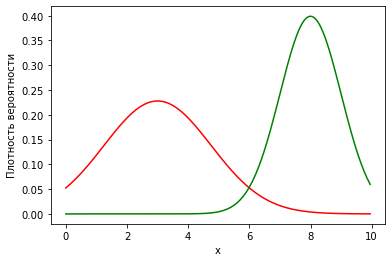

In [2]:
x=np.arange(0, 10, 0.05)
negative=norm.pdf(x, loc=3, scale=1.75)
positive=norm.pdf(x, loc=8, scale=1)
plt.plot(x, negative, color='r')
plt.plot(x, positive, color='g')
plt.xlabel('x')
plt.ylabel('Плотность вероятности')

### Классификация с помощью Линейной Регрессии

In [9]:
# Возьмем 2 признака и 1000 объектов
n_features = 2
n_objects = 1000

# сгенерируем вектор истинных весов
w_true = np.random.normal(size=(1, n_features ))

# сгенерируем матрицу X, вычислим Y с добавлением случайного шума
X = np.random.uniform(-7, 7, (n_objects, n_features))
shift=np.random.uniform(-3, 3)
Y = X.dot(w_true.T).flatten()+shift + np.random.normal(0, 0.5, size=(n_objects,))

Превращаем в классификацию

In [10]:
#Рассчитываем вероятности
Prob_negative=norm.pdf(Y, loc=3, scale=1.5)
Prob_positive=norm.pdf(Y, loc=8, scale=0.9)
prob=Prob_negative/(Prob_negative+Prob_positive)

#Генерируем лейблы классов
targets=np.where(np.random.uniform(size=Y.size)>prob, 1, 0)

Строим график вероятности принадлежности к положительному классу в зависимости от скрытой переменной

Text(0, 0.5, 'Вероятность принадлежности к положительному классу')

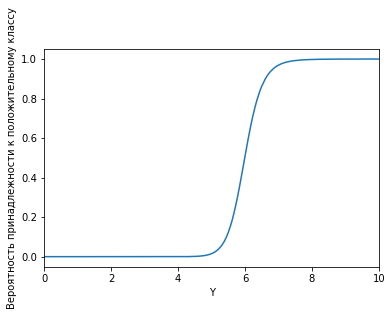

In [11]:
order=np.argsort(Y)
plt.plot(Y[order], 1-prob[order])
plt.xlim([0, 10])
plt.xlabel('Y')
plt.ylabel('Вероятность принадлежности к положительному классу')

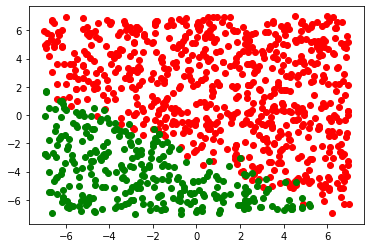

In [7]:
plt.scatter(X[targets==0, 0], X[targets==0, 1], color='r')
plt.scatter(X[targets==1, 0], X[targets==1, 1], color='g')

In [13]:
mod=linear_regression(eta=0.01)
mod.fit(X, np.where(targets==1, 1, -1))
predicted_Targets=(mod.predict(X).flatten()>0).astype(int)
print('Точность Линейной Регрессии составляет: {0}'.format(
        np.sum(predicted_Targets==targets)/len(targets)))

Точность Линейной Регрессии составляет: 0.969


In [14]:
w_true, mod.w

(array([[-1.63410236, -0.40711881]]), array([[-0.15792763, -0.03736901]]))

In [15]:
shift, mod.w0

(0.3404650495031145, -0.4895862352858952)

## Логистическая регрессия

In [16]:
def log_loss_and_grad(w, X, target):
    m = X.shape[0]
    y=(2*target-1)
    score=np.dot(X, w.T).flatten()
    
    # Рассчёт log_loss
    loss = np.sum(np.log(1+np.exp(-y*score)))/m 
    
    # Рассчёт градиента
    Z=-y/(m*(1+np.exp(y*score)))
    grad=Z[np.newaxis, :].dot(X)
    return loss, grad


def optimize(w, X, y, n_iterations, eta):
    #     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss_and_grad(w, X, y)
        w = w - eta * grad
        losses.append(loss)
        
    return w, losses

def predict(w, X):
    y_predicted = np.zeros(X.shape[0])  
    score=np.dot(X, w.T).flatten()
    Prob = 1/(1+np.exp(-score))
    
    #     За порог отнесения к тому или иному классу примем вероятность 0.5
    y_predicted[Prob>0.5]=1
    y_predicted[Prob<=0.5]=0
        
    return y_predicted

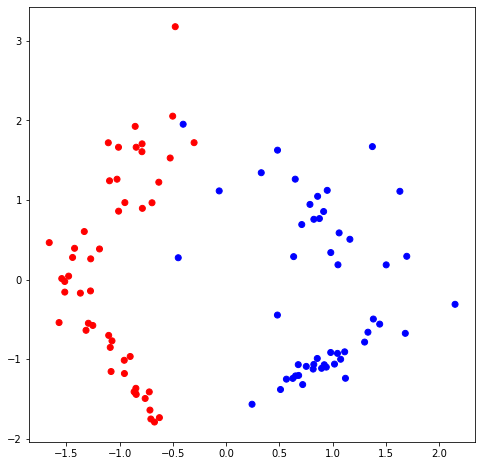

In [17]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=100, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=1)
# datasets.make_blobs(centers = 2, cluster_std = 1.5, random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)

In [18]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.7
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (70, 2)
Размер массива признаков тестовой выборки (30, 2)
Размер массива ответов для обучающей выборки (70,)
Размер массива ответов для тестовой выборки (30,)


In [19]:
w0 = np.zeros((1, X_train.shape[1]))

n_iterations = 1000
eta = 0.05

w, losses = optimize(w0, X_train, y_train, n_iterations, eta)

y_predicted_test = predict(w, X_test)
y_predicted_train = predict(w, X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[3.72659902 0.22383415]]
Точность на обучающей выборке: 98.571
Точность на тестовой выборке: 96.667


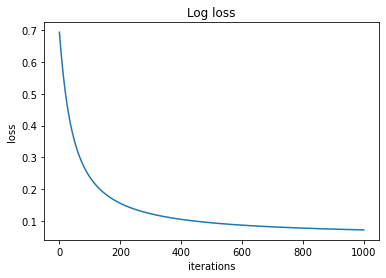

In [20]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses)

#### В виде класса

In [21]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations=1000
        self.eta=eta
    def _log_grad(self, X, target):
        m = X.shape[0]
        y=(2*target-1)
        score=np.dot(X, self.w.T).flatten()+self.w0
        Z=-y/(m*(1+np.exp(y*score)))
        grad=Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m
    def _optimize(self, X, target):
        for i in range(self.n_iterations):        
            grad_w, grad_w0 = self._log_grad(X, target)
            self.w = self.w-self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        self._optimize(X, target)
    def predict_proba(self, X):  
        '''
        Рассчёт вероятности
        '''
        score=X.dot(self.w.T).flatten()+self.w0
        return 1/(1+np.exp(-score))
    def predict(self, X, thr=0.5):
        proba=self.predict_proba(X)
        y_predicted = np.zeros(proba.shape, dtype=bool) 
        y_predicted[proba>thr]=1
        y_predicted[proba<=thr]=0
        return y_predicted

In [22]:
mod=logistic_regression()
mod.fit(X_train, y_train)
y_predicted_test = mod.predict(X_test)
y_predicted_train = mod.predict(X_train)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test-y_test)*100.0)

print(f"Итоговый вектор весов w: {mod.w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")

Итоговый вектор весов w: [[0.32398168 0.01226158]]
Точность на обучающей выборке: 97.143
Точность на тестовой выборке: 96.667


In [25]:
mod.w[0, 0]/np.sum(mod.w), w[0, 0]/np.sum(w)

(0.9635336007587412, 0.9433393400219047)

## Матрица ошибок

In [26]:
def confusion(predicted, actual):
    TP=np.sum(np.logical_and(predicted==1, actual==1))
    FP=np.sum(np.logical_and(predicted==1, actual==0))
    FN=np.sum(np.logical_and(predicted==0, actual==1))
    TN=np.sum(np.logical_and(predicted==0, actual==0))
    return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [27]:
print("Для порога по вероятности 0.5 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test), y_test)}")
print("Для порога по вероятности 0.4 на тестовой выборке имеем:"+
      f" {confusion(mod.predict(X_test, 0.4), y_test)}")

Для порога по вероятности 0.5 на тестовой выборке имеем: {'TP': 15, 'FP': 0, 'FN': 1, 'TN': 14}
Для порога по вероятности 0.4 на тестовой выборке имеем: {'TP': 16, 'FP': 9, 'FN': 0, 'TN': 5}


In [28]:
cofusion_fixed=confusion(mod.predict(X_test), y_test)
sensitivity=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FN'])
specificity=cofusion_fixed['TN']/(cofusion_fixed['TN']+cofusion_fixed['FP'])
balanced_accuracy=(sensitivity+specificity)/2
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность {sensitivity},"+
      f"специфичность {specificity}, сбалансированную точность {balanced_accuracy}")

Для порога по вероятности 0.5 на тестовой выборке имеем: чувствительность 0.9375,специфичность 1.0, сбалансированную точность 0.96875


In [29]:
precision=cofusion_fixed['TP']/(cofusion_fixed['TP']+cofusion_fixed['FP'])
recall=sensitivity
f1_score=2*precision*recall/(precision+recall)
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: точность {precision},"+
      f"полноту {recall}, f1-скор {f1_score}")

Для порога по вероятности 0.5 на тестовой выборке имеем: точность 1.0,полноту 0.9375, f1-скор 0.967741935483871


## Методы оценки дискриминационной способности модели

Text(0, 0.5, 'Плотность вероятности')

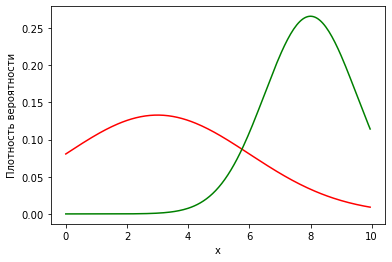

In [30]:
x=np.arange(0, 10, 0.05)
negative=norm.pdf(x, loc=3, scale=3)
positive=norm.pdf(x, loc=8, scale=1.5)
plt.plot(x, negative, color='r')
plt.plot(x, positive, color='g')
plt.xlabel('x')
plt.ylabel('Плотность вероятности')

Сгенерируем x относящиеся к двум классам, имеющим распределение как на картинке выше. 

In [33]:
#Генерируем метки классов
target=np.zeros((20,))
target[:np.random.randint(5, 15)]=1
np.random.shuffle(target)

# К какому бы распределению не относился x мы значение кумулятовнойй функции распределения
#cdf(x) всегда случайное число с равномерным распределением в интервале от 0 до 1 
#Значит мы можем сгенерировать сначала значения кумулятивной функции, а затем по ним получить x
cdf_values=np.random.uniform(0, 1, size=(20,)) 
x=np.empty(cdf_values.shape)
x[target==1]=norm.ppf(cdf_values[target==1], loc=8, scale=1.5)
x[target==0]=norm.ppf(cdf_values[target==0], loc=3, scale=3)

In [34]:
x

array([ 5.57588672,  1.29819668,  9.00256017,  7.67765739, -0.28500619,
        8.00089938,  6.47358776, -1.29085264, 10.1315927 ,  6.57925774,
        8.03410166,  6.71137491,  8.14899379,  9.26494174,  6.65993864,
        1.54098718,  5.91228334,  3.8622545 ,  7.34947409,  6.89552241])

In [32]:
target

array([0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 0.])

В ходе оценки дискриминационной способности при помощи ROC и PR-анализа мы хотим убедиться что с возрастанием x чаще встречаются объекты положительного класса(в target обозначаются как 1) и реже отрицательного(в target обозначаются как 0).

In [35]:
order=np.argsort(x)
target=target[order]
x=x[order]

In [36]:
for _x, t in zip(x, target):
    print("Значение x:{0} класс {1}".format(_x, t))

Значение x:-1.290852636743904 класс 0.0
Значение x:-0.28500618866419813 класс 0.0
Значение x:1.298196679133986 класс 0.0
Значение x:1.5409871782883442 класс 0.0
Значение x:3.8622544966049377 класс 0.0
Значение x:5.575886724073927 класс 1.0
Значение x:5.91228333614237 класс 1.0
Значение x:6.473587760173123 класс 1.0
Значение x:6.579257743053759 класс 1.0
Значение x:6.659938640302206 класс 1.0
Значение x:6.711374908580501 класс 1.0
Значение x:6.895522407203488 класс 0.0
Значение x:7.3494740893080905 класс 1.0
Значение x:7.677657393196497 класс 1.0
Значение x:8.000899379683391 класс 1.0
Значение x:8.03410166137117 класс 1.0
Значение x:8.148993790138608 класс 1.0
Значение x:9.002560169117649 класс 1.0
Значение x:9.264941742077275 класс 1.0
Значение x:10.131592695319984 класс 1.0


Далее мы должны подсчитать сколько объектов положительного и отрицательного класса относятся с тому или иному значению x. Поскольку повторяющихся x у нас нет, то относительно объектов положительного класса можно считать, что искомые значения это массив target, а для объектов негативного класса массив 1-target. Если бы у нас были повторяющиеся значения, мы бы должны были объединять и суммировать соответствующие ячейки в массивах

In [37]:
bins_pos=target
bins_neg=1-target
num_pos, num_neg=np.sum(bins_pos), np.sum(bins_neg)
print(f'{num_pos} объектов положительного класса, {num_neg} объектов негативного класса')

14.0 объектов положительного класса, 6.0 объектов негативного класса


Использование cumsum: 

In [38]:
np.cumsum([1, 2, 3])

array([1, 3, 6])

При помощи cumsum мы может посчитать сколко всего объектов негативного класса мы посчитали объектами негативного класса при текущем значении порога 

In [40]:
np.cumsum(bins_neg)

array([1., 2., 3., 4., 5., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6.,
       6., 6., 6.])

In [41]:
#Чувствительность, доля объектов негативного класса, которых при текущем значении предела
#правильно записали в негативный класс
TPR=np.concatenate([[0], np.cumsum(bins_neg)/num_neg])

#Ложно-позитивный уровень, доля объектов положительного класса, которых при текущем значении предела
#ошибочно записали в негативный класс
FPR=np.concatenate([[0], np.cumsum(bins_pos)/num_pos])

In [42]:
TPR

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [43]:
FPR

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.42857143, 0.5       , 0.57142857,
       0.64285714, 0.71428571, 0.78571429, 0.85714286, 0.92857143,
       1.        ])

Обратите внимание на то, что ROC-кривая(FPR, TPR) должна начинаться в точке (0,0) и (1,1). Эти точки соответствуют двум крайним значениям: когда при данном значении предела либо ни один объект не предсказывается как объект негативного класса, и когда при данном значении предела все объекты предсказываются как объекты негативного класса. <br>
В зависимости от того к какому классу причисляются объекты равные пределу, или, другими словами используем ли мы при отнесении объекта к классу сравнение его скора(или вероятности) с пределом через строгое или не строгое неравенство, у нас одна из этих двух точек может пропадать. Зная об этом факте мы можем добавить недостающую крайнюю точку к массивам. Собственно, для этого ранее и использовалось np.concatenate([[0], ...])  

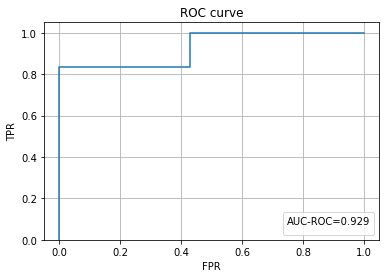

In [44]:
AUC_ROC = np.sum((FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1])/2)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

In [45]:
precision=np.cumsum(bins_neg)/(np.cumsum(bins_neg)+np.cumsum(bins_pos))
precision

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.83333333, 0.71428571, 0.625     , 0.55555556, 0.5       ,
       0.45454545, 0.5       , 0.46153846, 0.42857143, 0.4       ,
       0.375     , 0.35294118, 0.33333333, 0.31578947, 0.3       ])

In [46]:
recall = TPR
recall

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

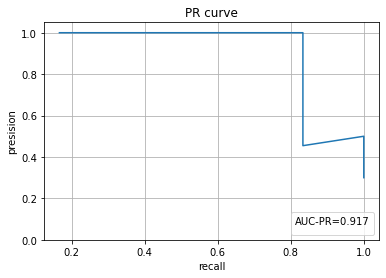

In [47]:
AUC_PR = np.sum(precision*(recall[1:]-recall[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)

<b>Домашнее задание:</b> Определите AUC_ROC и AUC_PR для модели         логистической регрессии на тестовой выборке. Используйте реализацию модели в виде класса и функцию confusion, чтобы рассчитать TPR, FPR, precision, recal для различных порогов вероятности.<br>
<i>Дополнительное задание(не обязательно):</i> Получите такие же характеристики для линейной регрессии и сравните две модели.

In [48]:
mod=logistic_regression()
mod.fit(X_train, y_train)
proba=np.unique(mod.predict_proba(X_test))

In [49]:
conf_mat_list=[]
for p in proba[::-1]:
    print("Для порога по вероятности {0} на тестовой выборке имеем:\n \t".format(p)+
      f" {confusion(mod.predict(X_test, p), y_test)}")
    conf_mat_list.append(confusion(mod.predict(X_test, p), y_test))

Для порога по вероятности 0.5996765491393211 на тестовой выборке имеем:
 	 {'TP': 0, 'FP': 0, 'FN': 16, 'TN': 14}
Для порога по вероятности 0.5814037305151907 на тестовой выборке имеем:
 	 {'TP': 1, 'FP': 0, 'FN': 15, 'TN': 14}
Для порога по вероятности 0.5792811063971612 на тестовой выборке имеем:
 	 {'TP': 2, 'FP': 0, 'FN': 14, 'TN': 14}
Для порога по вероятности 0.5743251614774529 на тестовой выборке имеем:
 	 {'TP': 3, 'FP': 0, 'FN': 13, 'TN': 14}
Для порога по вероятности 0.5709156918919097 на тестовой выборке имеем:
 	 {'TP': 4, 'FP': 0, 'FN': 12, 'TN': 14}
Для порога по вероятности 0.5690112812459007 на тестовой выборке имеем:
 	 {'TP': 5, 'FP': 0, 'FN': 11, 'TN': 14}
Для порога по вероятности 0.564394932280336 на тестовой выборке имеем:
 	 {'TP': 6, 'FP': 0, 'FN': 10, 'TN': 14}
Для порога по вероятности 0.5640365637648698 на тестовой выборке имеем:
 	 {'TP': 7, 'FP': 0, 'FN': 9, 'TN': 14}
Для порога по вероятности 0.5605485954538282 на тестовой выборке имеем:
 	 {'TP': 8, 'FP':